In [77]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from dotenv import load_dotenv
import json

# Foursquare API Results

Send a request to Foursquare with a small radius (1000m) for all the bike stations in your city of choice. 

In [3]:
# loading the .env file
load_dotenv()

Python-dotenv could not parse statement starting at line 7


True

In [16]:
# assigning stored api_key in .env file to vairables
api_key = os.environ.get('FOURSQUARE_API_KEY')

In [5]:
# setting up base_url for foursquare
fsq_url = "https://api.foursquare.com/v3/places/search"

# Headers for authorization (api key)
fsq_headers = {
	"Accept": "application/json",
    "Authorization": api_key
}

In [6]:
# reading in the CityBikes - BikeShareToronto.csv (created in city_bikes.ipynb)
cityBikes = pd.read_csv('BikeShareToronto.csv')
cityBikes

# Pulling all bike stations in toronto, we get 717 stations in total, with their respective lat/lon's and the availibility of free bikes.

,Unnamed: 0,latitude,longitude,free_bikes
0,0,43.665269,-79.319796,18
1,1,43.671420,-79.445947,2
2,2,43.666224,-79.317693,10
3,3,43.653236,-79.376716,4
4,4,43.663722,-79.380288,23
...,...,...,...,...
712,712,43.601915,-79.499419,1
713,713,43.642852,-79.531995,1
714,714,43.650945,-79.379498,0
715,715,43.707356,-79.437231,0


### Instead of calculating Euclidean distance, comparing each latitude/longitude of bars/resturants/libraries to each latitude/longitude of each bike station, instead we're going to feed the latitudes/longitudes of each bike stop into the Foursquare API call, adjusting the radius to 1000m (1km) and setting the limit to the maximum of 50 - this will give us the total number of POI's (depending on what our search category is) within a 1k radius of each bike station.

In [7]:
# setting up lat and lon values for cityBike stations
lat = cityBikes['latitude'].values # will give a numpy array of each bike station latitude
lon = cityBikes['longitude'].values
len_cityBikes = len(cityBikes) # will give the number of bike stations - were going to use this length/value below when we iterate using a for-loop.

Parse through the response to get the POI (such as restaurants, bars, etc) details you want (ratings, name, location, etc)

In [ ]:
# intitialising lists for number of bars and libs and the minimum distance to the closest bar and lib within a 1000m (1km) radius of each bike stand. 
# These will ulitmately be added to to cityBikes dataFrame and used for modelling and EDA. The goal here is to rid away with joinig tables with pandas or SQL and essentially,
# perform everything uptream. This method ensure data validity and integrity - ensuring no duplicates and issues that come about with joining on keys etc..


num_of_bars = [] # number of bars within 1km of bike station
num_of_libs = [] # ||
min_bars_dist = [] # distance of closest bar to bike station in meters
min_libs_dist = [] # ||


for k in range(0, 4): # iterating through range all the way up to len of cityBikes (717 bike stations)
    ll = f'{lat[k]},{lon[k]}' # this is concatinating the lat and lon of each bikeStation which will be fed into the Fouraquare API.

    fsq_params = {
        "categories": '13003', # searching for Bars here
        "ll": ll,
        "radius": 1000, # bars withing 1000m or (1km) of each bike station
        "limit": 50 # max limit of results (max limit allowed anyway..)
    }

    response = requests.request("GET", fsq_url, params=fsq_params, headers=fsq_headers)

    data = response.json()


    num_of_bars.append(len(data['results'])) # appending number of bars (within a 1km distance) for every bike station to the above created list

    # Appending the bars' distance, more specifically the one with the closest or minimum distance for every bike station.
    # Error handling incase ['distance'] may not exist.
    try:
        min_bars_dist.append(pd.json_normalize(data['results'])['distance'].min()) # appending the minimum distance found of all distances within 1km of bike station
    except KeyError:
        min_bars_dist.append(None) # Will fill with 0 incase distance does not exist.

    # Like we peformed above for 'bars' instead now we're looking at 'libraries'.
    fsq_params = {
        "categories": '12080', # library category id/code
        "ll": ll, # feeding in each bike station lat/lon.
        "radius": 1000, # libraries within 1000m or (1km) of each bike station
        "limit": 50 # max limit of results
    }

    response = requests.request("GET", fsq_url, params=fsq_params, headers=fsq_headers)

    data = response.json()


    num_of_libs.append(len(data['results']))  # appending number of library's for every bike station (within a 1km distance) to the above created list
    
    # Error handling incase ['distance'] may not exist.
    try:
        min_libs_dist.append(pd.json_normalize(data['results'])['distance'].min())
    except KeyError:
        min_libs_dist.append(None)

In [ ]:
# printing all possible info given by JSON but we wont be needing most of it - nonetheless it gives an idea of what it all looks like,
# atleast a single row.
pd.json_normalize(data['results']) 

Put your parsed results into a DataFrame

In [ ]:
# Using the above created, here we're building out the DataFrame - 'bike_station#', 'latitude', 'longitude' and 'free_bikes' come from the BikeShareToronto.csv but 'num_of_bars'
# 'min_bar_dist', 'num_of_libs' and 'min_libs_dist' were created from the foursquare API.

df_bikes = cityBikes.iloc[:,:] # selecting the desired rows and all columns from cityBikes

# Creating new columns for number of bars and libraries within 1km radius and the bar and lib with minimum distance to bike station
df_bikes['num_of_bars'] = num_of_bars
df_bikes['min_bar_dist'] = min_bars_dist
df_bikes['num_of_libs'] = num_of_libs
df_bikes['min_libs_dist'] = min_libs_dist

# renaming column' 'Unnamed: 0' to 'bike_station#'.
df_bikes = df_bikes.rename(columns={'Unnamed: 0': 'bike_station#'})

# Exporting csv
df_bikes.to_csv('fsq_BarLibs_BikeRadius.csv')

df_bikes


Reading in the csv created by the above as I made the api call for foursquare in a seperate file and dont want to run it again. Please see file: 'bike_poi_radius_fsq.ipynb' for 
more detail and outputs of each code block.

In [21]:
# df_bikes_radius_fsq = pd.read_csv('fsq_BarLibs_BikeRadius.csv')
# df_bikes_radius_fsq

,Unnamed: 0,bike_station#,latitude,longitude,free_bikes,num_of_bars,min_bar_dist,num_of_libs,min_libs_dist
0,0,0,43.665269,-79.319796,18,11,608.0,2,810.0
1,1,1,43.671420,-79.445947,2,19,292.0,1,664.0
2,2,2,43.666224,-79.317693,10,8,413.0,2,766.0
3,3,3,43.653236,-79.376716,4,50,122.0,9,302.0
4,4,4,43.663722,-79.380288,23,46,43.0,6,555.0
...,...,...,...,...,...,...,...,...,...
712,712,712,43.601915,-79.499419,1,0,NaN,1,885.0
713,713,713,43.642852,-79.531995,1,8,159.0,0,NaN
714,714,714,43.650945,-79.379498,0,50,139.0,0,NaN
715,715,715,43.707356,-79.437231,0,0,NaN,0,NaN


# Yelp API Results

Send a request to Yelp with a small radius (1000m) for all the bike stations in your city of choice. 

In [13]:
# loading the .env file
load_dotenv()

Python-dotenv could not parse statement starting at line 7


True

In [15]:
# assigning stored api_key in .env file to vairables
api_key = os.environ.get('YELP4')

In [17]:
# Setting up base_url for YELP
url='https://api.yelp.com/v3/businesses/search'

# Headers for authorization (api key)
headers = {
    'Authorization': 'Bearer %s' % api_key
}

In [18]:
# reading in the CityBikes - Toronto Bike Share csv from city_bikes.ipynb
cityBikes = pd.read_csv('BikeShareToronto.csv')
cityBikes

# Pulling all bike stations in toronto, we get 717 stations in total, with their respective lat/lon's and the availibility of free bikes.

,Unnamed: 0,latitude,longitude,free_bikes
0,0,43.665269,-79.319796,18
1,1,43.671420,-79.445947,2
2,2,43.666224,-79.317693,10
3,3,43.653236,-79.376716,4
4,4,43.663722,-79.380288,23
...,...,...,...,...
712,712,43.601915,-79.499419,1
713,713,43.642852,-79.531995,1
714,714,43.650945,-79.379498,0
715,715,43.707356,-79.437231,0


### Instead of calculating Euclidean distance, comparing each latitude/longitude of bars/resturants/libraries to each latitude/longitude of each bike station, instead we're going to feed the latitudes/longitudes of each bike stop into the YELP API call, adjusting the radius to 1000m (1km) and setting the limit to the maximum of 50 - this will give us the total number of POI's (depending on what our search category is) within a 1k radius of each bike station.

In [19]:
# setting up lat and lon values for cityBike stations
lat = cityBikes['latitude'].values # will give a numpy array of each bike station latitude
lon = cityBikes['longitude'].values
len_cityBikes = len(cityBikes) # will give the number of bike stations - were going to use this length/value below when we iterate using a for-loop.

Parse through the response to get the POI (such as restaurants, bars, etc) details you want (ratings, name, location, etc)

In [ ]:
# intitialising lists for number of bars and libs and the minimum distance to the closest bar and lib within a 1000m (1km) radius of each bike stand. 
# These will ulitmately be added to to cityBikes dataFrame and used for modelling and EDA. The goal here is to rid away with joinig tables with pandas or SQL and essentially,
# perform everything uptream. This method ensure data validity and integrity - ensuring no duplicates and issues that come about with joining on keys etc..

num_of_bars = [] # number of bars within 1km of bike station
avg_bar_rating = [] # average bar rating for number of bars in near given ike station
num_of_libs = [] # same as above but for libraries
avg_lib_rating = [] # average lib rating for number of libs in near given bike station
min_bars_dist = [] # distance of closest bar to bike station in meters
min_libs_dist = [] # || for libraries


# Unlike with the Foursquare API (where the rate limit is much higher than 500), were only grabing first 250 lat/long values from BikeShareToronto.csv. Given that we're 
# querying the API twice, once for bars and once for library's, we make two calls per bike station, and with a rate limit of 500, we can only query 250 bike stations. 
# This will prove to be a bottleneck and will give favour to the foursquare API. In addition, the YELP website was experiencing downtime throughout the project where 
# even logging-in or creating an account would result in error 403 - blocked traffic. We tried using a VPN however, we still couldnt work well with the Yelp API. 
# As a result, we were only able to query 250 of the bike stations through the Yelp api.
for k in range(0, 250): 
    ll = f'{lat[k]},{lon[k]}' # this is concatinating the lat and lon of each bikeStation which will be fed into the Fouraquare API.

    # finding bars
    params = {
        'term':'bars',
        'location': ll,
        'radius': 1000, # bars withing 1000m or (1km) of each bike station
        'limit': 50 # max limit of results
    }
    
    response = requests.get(url, params=params, headers=headers)

    data = response.json()

    num_of_bars.append(len(data['businesses'])) # appending number of bars (within a 1km distance) for every bike station to the above created list

    # Appending the bars' distance, more specifically the one with the closest or minimum distance for every bike station.
    # error handling incase ['distance'] may not exist.
    try:
        min_bars_dist.append(round(pd.json_normalize(data['businesses'])['distance'].min(), 2)) # appending bar with minimum distance of bike station
    except KeyError:
        min_bars_dist.append(None)

    # Extract ratings from businesses - unlike in the foursquare API, the YELP API provides users with ratings for bars. So along with the number of bars for every bike station, 
    # the average rating of those bars will be calcualted and be present as a column in the final DataFrame.
    ratings = [business.get('rating', None) for business in data['businesses']]
    # Filter out None values
    valid_ratings = [rating for rating in ratings if rating is not None]

    if valid_ratings:  # Check if there are valid ratings
        avg_rating = sum(valid_ratings) / len(valid_ratings)
    else:
        avg_rating = None # will give 0 incase no ratings exist
    
    avg_bar_rating.append(avg_rating) # appending the average rating to the 'avg_bar_rating' list.
    
    # Like for bars, we're searching for librarys now.
    params = {
        'term':'library',
        'location': ll, # will be feeding in bike station lat/longs from BikeShareToronto.csv
        'radius': 1000, # library's withing 1000m or (1km) of each bike station
        'limit': 50 
    }

    response = requests.get(url, params=params, headers=headers)

    data = response.json()

    
    num_of_libs.append(len(data['businesses']))  # appending number of library's for every bike station (within a 1km distance) to the above created list

    # Error handling incase ['distance'] may not exist. extracting the bar with the shortest distance for every bike station.
    try:
        min_libs_dist.append(round(pd.json_normalize(data['businesses'])['distance'].min(), 2))
    except KeyError:
        min_libs_dist.append(None)

     # Extract ratings from businesses
    ratings = [business.get('rating', None) for business in data['businesses']]
    # Filter out None values
    valid_ratings = [rating for rating in ratings if rating is not None]

    if valid_ratings:  # Check if there are valid ratings
        avg_rating = sum(valid_ratings) / len(valid_ratings)
    else:
        avg_rating = None
    
    avg_lib_rating.append(avg_rating)


In [ ]:
# normalizing the JSON
pd.json_normalize(data['businesses'])

Put your parsed results into a DataFrame

In [ ]:
# Using the above created, here we're building out the DataFrame - 'bike_station#', 'latitude', 'longitude' and 'free_bikes' come from the BikeShareToronto.csv but 'num_of_bars'
# 'min_bar_dist', 'num_of_libs' and 'min_libs_dist' were created from the foursquare API.

df_bikes_bars_libs = cityBikes.iloc[:250,:]

# creating new columns for number of bar and libraries within 1km radius and the bar and lib with minimum distance to bike station as well as average rating of bars and libraries.
df_bikes_bars_libs['num_of_bars'] = num_of_bars
df_bikes_bars_libs['avg_bar_rating'] = avg_bar_rating
df_bikes_bars_libs['min_bar_dist'] = min_bars_dist
df_bikes_bars_libs['num_of_libs'] = num_of_libs
df_bikes_bars_libs['avg_lig_rating'] = avg_lib_rating
df_bikes_bars_libs['min_lib_dist'] = min_libs_dist


# renaming column' 'unnamed: 0' to 'bike_station#'
df_bikes_bars_libs = df_bikes_bars_libs.rename(columns={'Unnamed: 0': 'bike_station#'})

# Exporting csv
df_bikes_bars_libs.to_csv('yelp_BarLibs_BikeRadius1.csv')

df_bikes_bars_libs

Reading in the csv created by the above as I made the api call for YELP in a seperate file and am currently at my maximum amount of calls. Please see file: 'bike_poi_radius_yelp.ipynb' for 
more detail and to see outputs of each code block.

In [20]:
df_bikes_bars_libs = pd.read_csv('yelp_BarLibs_BikeRadius1.csv')
df_bikes_bars_libs

,Unnamed: 0,bike_station#,latitude,longitude,free_bikes,num_of_bars,avg_bar_rating,min_bar_dist,num_of_libs,avg_lig_rating,min_lib_dist
0,0,0,43.665269,-79.319796,18,16,4.00000,216.73,1,3.500000,789.09
1,1,1,43.671420,-79.445947,2,10,3.05000,598.29,2,3.750000,688.66
2,2,2,43.666224,-79.317693,10,16,3.71875,341.48,1,3.500000,765.56
3,3,3,43.653236,-79.376716,4,50,3.87000,130.70,10,3.500000,561.35
4,4,4,43.663722,-79.380288,23,50,3.66000,62.99,9,3.944444,594.79
...,...,...,...,...,...,...,...,...,...,...,...
245,245,245,43.685569,-79.408019,0,2,3.50000,800.23,0,NaN,NaN
246,246,246,43.651678,-79.375233,1,50,3.80000,70.31,8,3.562500,435.89
247,247,247,43.651838,-79.378743,1,50,3.86000,89.87,8,3.812500,399.87
248,248,248,43.665221,-79.394009,1,50,3.73000,357.20,19,3.973684,166.38


# Comparing Results

Which API provided you with more complete data? Provide an explanation. 

Foursquare Results

In [23]:
# dropping the column 'Unnamed: 0' as it is the exact same as 'bike_station#'
df_bikes_radius_fsq = df_bikes_radius_fsq.drop(columns='Unnamed: 0')
df_bikes_radius_fsq


,bike_station#,latitude,longitude,free_bikes,num_of_bars,min_bar_dist,num_of_libs,min_libs_dist
0,0,43.665269,-79.319796,18,11,608.0,2,810.0
1,1,43.671420,-79.445947,2,19,292.0,1,664.0
2,2,43.666224,-79.317693,10,8,413.0,2,766.0
3,3,43.653236,-79.376716,4,50,122.0,9,302.0
4,4,43.663722,-79.380288,23,46,43.0,6,555.0
...,...,...,...,...,...,...,...,...
712,712,43.601915,-79.499419,1,0,NaN,1,885.0
713,713,43.642852,-79.531995,1,8,159.0,0,NaN
714,714,43.650945,-79.379498,0,50,139.0,0,NaN
715,715,43.707356,-79.437231,0,0,NaN,0,NaN


With the Foursquare API and its high rate limit, we were able to feed in all 717 bike stations and thus have more data

YELP API Results

In [28]:
# df_bikes_bars_libs = df_bikes_bars_libs.drop(columns='Unnamed: 0')
df_bikes_bars_libs


,bike_station#,latitude,longitude,free_bikes,num_of_bars,avg_bar_rating,min_bar_dist,num_of_libs,avg_lig_rating,min_lib_dist
0,0,43.665269,-79.319796,18,16,4.00000,216.73,1,3.500000,789.09
1,1,43.671420,-79.445947,2,10,3.05000,598.29,2,3.750000,688.66
2,2,43.666224,-79.317693,10,16,3.71875,341.48,1,3.500000,765.56
3,3,43.653236,-79.376716,4,50,3.87000,130.70,10,3.500000,561.35
4,4,43.663722,-79.380288,23,50,3.66000,62.99,9,3.944444,594.79
...,...,...,...,...,...,...,...,...,...,...
245,245,43.685569,-79.408019,0,2,3.50000,800.23,0,NaN,NaN
246,246,43.651678,-79.375233,1,50,3.80000,70.31,8,3.562500,435.89
247,247,43.651838,-79.378743,1,50,3.86000,89.87,8,3.812500,399.87
248,248,43.665221,-79.394009,1,50,3.73000,357.20,19,3.973684,166.38


## Comparison

While the YELP api was able to provide slightly more details, like 'ratings' for bars, which allowed for calculations like 'avg_bar_rating' or 'avg_lib_rating' for every bike station (which can be seen above) it suffers from a low rate limit of 500 calls. Given that we query the API twice for each bike station (once searching for 'bars' and again for 'library'), we were only able to query the YELP API with 250 of the bike stations lat/long values.

In constrast, the Foursquares rate limit is much higher so we were able to feed in all 717 bike stations' latitude and longitude coordinates and gather all the data we needed. This will ultimately prove much more effective when modeling as the more data we have the better.

Should we have had more time, we'd query the YELP api over three days (250 rows, 250 rows and 217 rows) producing 3 datasets and concatenate or 'stack' them using the pandas.concat() function.

Having the complete YELP data would provide for a more comprehensive comparison. That being said, given how we fed the bike station lat and long values into each API, in the same order, both datasets show all bike stations in the same exact order, so we can compare the first 250 rows of the Foursquare results to the YELP results row by row, side by side.


In [63]:
# the first 250 rows of Foursquare results
df_bikes_radius_fsq250 = df_bikes_radius_fsq[0:250].drop(columns='lat_long')
df_bikes_radius_fsq250

,bike_station#,latitude,longitude,free_bikes,num_of_bars,min_bar_dist,num_of_libs,min_libs_dist
0,0,43.665269,-79.319796,18,11,608.0,2,810.0
1,1,43.671420,-79.445947,2,19,292.0,1,664.0
2,2,43.666224,-79.317693,10,8,413.0,2,766.0
3,3,43.653236,-79.376716,4,50,122.0,9,302.0
4,4,43.663722,-79.380288,23,46,43.0,6,555.0
...,...,...,...,...,...,...,...,...
245,245,43.685569,-79.408019,0,2,829.0,1,872.0
246,246,43.651678,-79.375233,1,50,86.0,0,NaN
247,247,43.651838,-79.378743,1,50,199.0,11,214.0
248,248,43.665221,-79.394009,1,42,376.0,24,201.0


In [57]:
# All YELP results
df_bikes_bars_libs

,bike_station#,latitude,longitude,free_bikes,num_of_bars,avg_bar_rating,min_bar_dist,num_of_libs,avg_lig_rating,min_lib_dist
0,0,43.665269,-79.319796,18,16,4.00000,216.73,1,3.500000,789.09
1,1,43.671420,-79.445947,2,10,3.05000,598.29,2,3.750000,688.66
2,2,43.666224,-79.317693,10,16,3.71875,341.48,1,3.500000,765.56
3,3,43.653236,-79.376716,4,50,3.87000,130.70,10,3.500000,561.35
4,4,43.663722,-79.380288,23,50,3.66000,62.99,9,3.944444,594.79
...,...,...,...,...,...,...,...,...,...,...
245,245,43.685569,-79.408019,0,2,3.50000,800.23,0,NaN,NaN
246,246,43.651678,-79.375233,1,50,3.80000,70.31,8,3.562500,435.89
247,247,43.651838,-79.378743,1,50,3.86000,89.87,8,3.812500,399.87
248,248,43.665221,-79.394009,1,50,3.73000,357.20,19,3.973684,166.38


In [67]:
# We can count how many total bars and librarys were found for the set of 250 bike stations for both datasets

totalbars_fsq = df_bikes_radius_fsq250['num_of_bars'].sum()
totallibs_fsq = df_bikes_radius_fsq250['num_of_libs'].sum()

print(f'Foursquare results - total bars: {totalbars_fsq}, total libs: {totallibs_fsq}')

totalbars_yelp = df_bikes_bars_libs['num_of_bars'].sum()
totallibs_yelp = df_bikes_bars_libs['num_of_libs'].sum()

print(f'Yelp results - total bars: {totalbars_yelp}, total libs: {totallibs_yelp}')


Foursquare results - total bars: 7065, total libs: 1135
Yelp results - total bars: 8233, total libs: 890


We can see that while the YELP api provided a greater number of bars, it however produced a lesser number of libraries. While this is only a subset of 250 rows, its tough to say how the remainder of the YELP results, would turn out.

We can also see that there are a number of 'NaN' values in the distance-related columns for both datasets, so we can also see which one had more occurances of NaN's. In the end, we will continue to go on and model with foursquare results however, lets take a look at the first 250 rows:

In [70]:
totalBarDist_Nan_fsq = df_bikes_radius_fsq250['min_bar_dist'].isna().sum()
totalLibDist_Nan_fsq = df_bikes_radius_fsq250['min_libs_dist'].isna().sum()

print(f'Foursquare results - total NaN (min_bar_dist): {totalBarDist_Nan_fsq}, total NaN (min_libs_dist): {totalLibDist_Nan_fsq}')

totalBarDist_Nan_yelp = df_bikes_bars_libs['min_bar_dist'].isna().sum()
totalLibDist_Nan_yelp = df_bikes_bars_libs['min_lib_dist'].isna().sum()

print(f'Yelp results - total NaN (min_bar_dist): {totalBarDist_Nan_yelp}, total NaN (min_lib_dist): {totalLibDist_Nan_yelp}')


Foursquare results - total NaN (min_bar_dist): 22, total NaN (min_libs_dist): 33
Yelp results - total NaN (min_bar_dist): 4, total NaN (min_lib_dist): 29


Comparing the first 250 rows, it shows that the Foursquare has more NaN values present - it seems unreasonable to impute such values so they will most likely be removed (rows containing) from the dataset.

## Get the top 10 bike stations with the highest local average rating for both Bars and Librarys

Given that the YELP dataset is the only one that gives us ratings, we will answer this question using it.

In [73]:
# We can filter out any NaN ratings first:
df_bikes_bars_libs_cleanRatings = df_bikes_bars_libs.dropna(subset=['avg_bar_rating', 'avg_lig_rating']).reset_index(drop=True)
df_bikes_bars_libs_cleanRatings

,bike_station#,latitude,longitude,free_bikes,num_of_bars,avg_bar_rating,min_bar_dist,num_of_libs,avg_lig_rating,min_lib_dist
0,0,43.665269,-79.319796,18,16,4.00000,216.73,1,3.500000,789.09
1,1,43.671420,-79.445947,2,10,3.05000,598.29,2,3.750000,688.66
2,2,43.666224,-79.317693,10,16,3.71875,341.48,1,3.500000,765.56
3,3,43.653236,-79.376716,4,50,3.87000,130.70,10,3.500000,561.35
4,4,43.663722,-79.380288,23,50,3.66000,62.99,9,3.944444,594.79
...,...,...,...,...,...,...,...,...,...,...
215,243,43.642830,-79.384090,9,50,3.61000,26.88,1,4.500000,999.66
216,244,43.651820,-79.474210,11,5,3.70000,116.05,3,3.666667,30.49
217,246,43.651678,-79.375233,1,50,3.80000,70.31,8,3.562500,435.89
218,247,43.651838,-79.378743,1,50,3.86000,89.87,8,3.812500,399.87


Seems to have dropped about 30 rows....

In [74]:
# Top 10 bike stations with the highest average bar ratings (within 1km)
df_bars_cleanRatingsSorted = df_bikes_bars_libs_cleanRatings.sort_values(by='avg_bar_rating', ascending=False).head(10)
df_bars_cleanRatingsSorted

,bike_station#,latitude,longitude,free_bikes,num_of_bars,avg_bar_rating,min_bar_dist,num_of_libs,avg_lig_rating,min_lib_dist
208,236,43.678685,-79.297974,6,4,4.250000,72.39,1,4.000000,969.60
13,13,43.663993,-79.358534,9,11,4.227273,562.14,1,4.000000,470.13
150,169,43.651281,-79.411717,10,50,4.180000,22.56,2,3.500000,507.05
85,95,43.659195,-79.329196,4,12,4.166667,306.95,1,3.000000,868.18
71,80,43.640634,-79.435841,17,20,4.150000,83.90,1,3.500000,290.75
51,55,43.636731,-79.444966,15,11,4.136364,243.05,2,2.250000,588.71
152,171,43.655000,-79.418889,17,50,4.130000,44.94,1,4.000000,110.54
204,230,43.639700,-79.448650,18,12,4.083333,223.33,3,1.833333,154.36
201,227,43.665870,-79.334430,14,25,4.080000,375.41,1,3.000000,17.39
196,222,43.640255,-79.439223,15,25,4.080000,50.77,2,2.250000,566.15


In [76]:
# Top 10 bike stations with the highest average library ratings (within 1km)
df_libs_cleanRatingsSorted = df_bikes_bars_libs_cleanRatings.sort_values(by='avg_lig_rating', ascending=False).head(10)
df_libs_cleanRatingsSorted

,bike_station#,latitude,longitude,free_bikes,num_of_bars,avg_bar_rating,min_bar_dist,num_of_libs,avg_lig_rating,min_lib_dist
215,243,43.642830,-79.384090,9,50,3.61,26.88,1,4.500000,999.66
41,42,43.643667,-79.380414,7,50,3.61,95.32,3,4.500000,906.90
156,175,43.695950,-79.328535,5,2,2.25,149.94,1,4.500000,431.15
10,10,43.671944,-79.387778,0,50,3.63,118.26,10,4.350000,58.79
91,102,43.645209,-79.396074,8,50,3.87,26.76,3,4.333333,763.90
180,202,43.645323,-79.395003,12,50,3.90,24.96,3,4.333333,801.87
121,136,43.669969,-79.386532,0,50,3.66,79.84,10,4.300000,104.61
8,8,43.675492,-79.388858,16,50,3.71,72.43,7,4.285714,409.84
206,232,43.673768,-79.391253,0,50,3.68,244.89,9,4.277778,309.24
56,60,43.670454,-79.390140,0,50,3.70,24.60,13,4.269231,220.30


# Creating visualisations to better understand the Data

### Scatter plot - Latitude vs Longitude

Will give a spatial overview of the bike station locations - we can see a geo distribution of the bike stations in Toronto - we can sample 100 bike stations from each dataset.

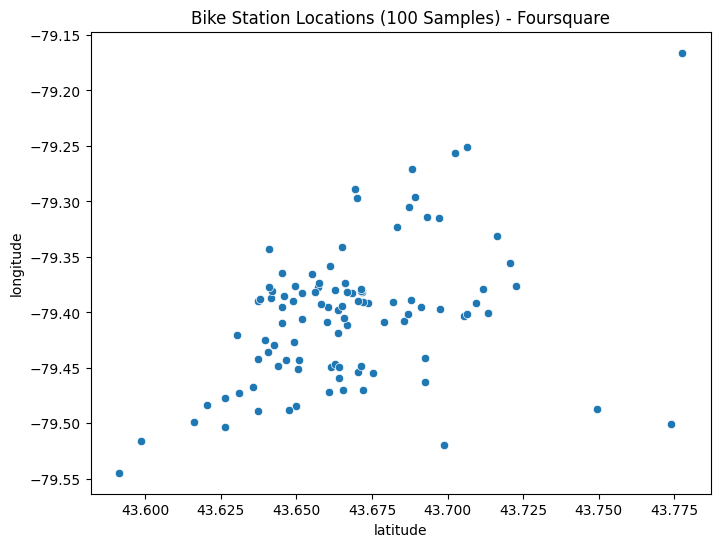

In [83]:
# Foursquare results
plt.figure(figsize = (8,6))
df_bikes_radius_fsq_sample = df_bikes_radius_fsq.sample(n=100)
sns.scatterplot(x='latitude', y='longitude', data=df_bikes_radius_fsq_sample)
plt.title('Bike Station Locations (100 Samples) - Foursquare')
plt.show()

# we can see a concentration of bike stations in latitude range of ~43.625 - 43.685 and longitude ~ -79.45 - -79.35


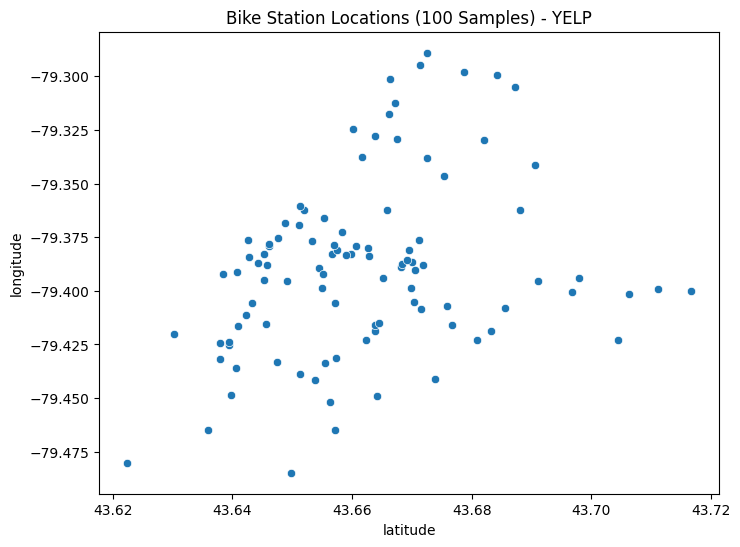

In [84]:
# YELP results 
plt.figure(figsize = (8,6))
df_bikes_bars_libs_sample = df_bikes_bars_libs.sample(n=100)
sns.scatterplot(x='latitude', y='longitude', data=df_bikes_bars_libs_sample)
plt.title('Bike Station Locations (100 Samples) - YELP')
plt.show()

# we see a slight yet noticeable difference in the distribution of bike stations - this is evidently because the foursquare scatterplot is sampling from 717 rows of data while the YELP scatterplot is sampling from only 250 rows of data.

### Histogram - free bikes

Will give us a distribution of free bikes at every bike station - it should be noted that the 'free bikes' data is coming from the BikeShareToronto.csv and the cityBikes API was queried in the late afternoon/early evening time on a thursday and will be reflective of that.

Both the Foursquare and YELP datasets (barring the fact that YELP dataset is only 250 rows long) have the same bike stations.

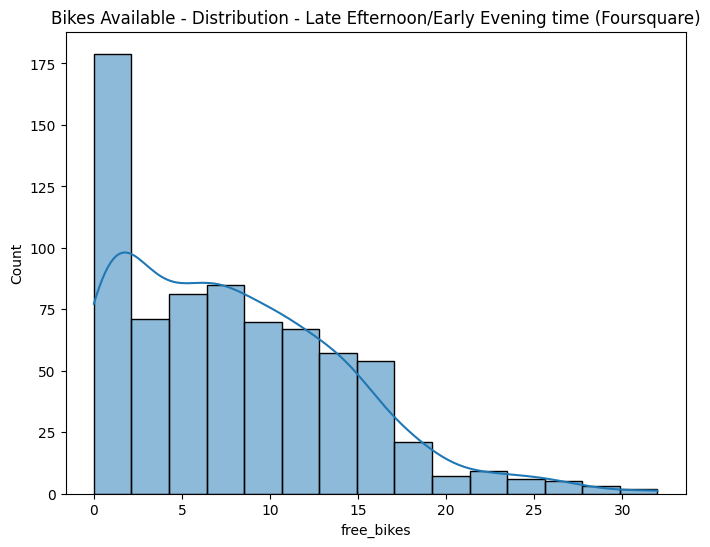

In [89]:
plt.figure(figsize=(8,6))
sns.histplot(df_bikes_radius_fsq['free_bikes'], bins=15, kde=True)
plt.title('Bikes Available - Distribution - Late Efternoon/Early Evening time (Foursquare)')
plt.show()

# 717 rows of date - n = 717

# Distribution is skewed to the right, with many stations showing 15 bikes or less and many of those having 0! People coming home from work? Going out to leisurely activities??? 

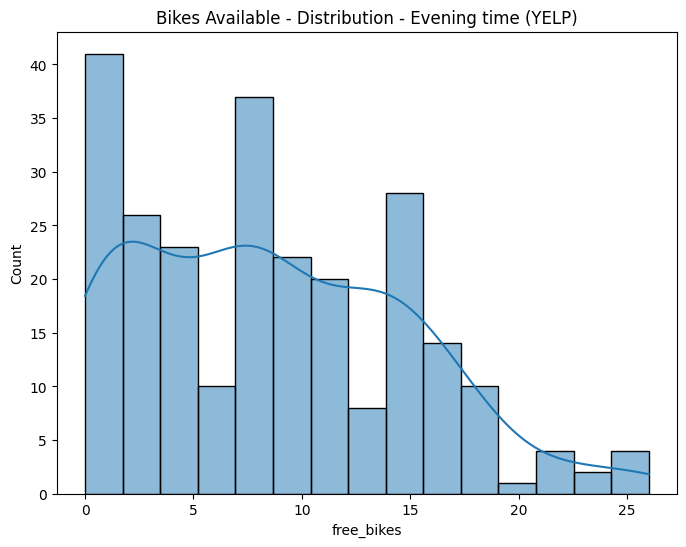

In [88]:
plt.figure(figsize=(8,6))
sns.histplot(df_bikes_bars_libs['free_bikes'], bins=15, kde=True)
plt.title('Bikes Available - Distribution - Evening time (YELP)')
plt.show()

# We see a slightly different distribution, skewed to the right again and many stations with 0, 5-10 and ~15 bikes availble. I think with the remaining 467, we'd see the same distribution as Foursquare, given that this data is pulling from the cityBikes api.

### Correlation Matrix

Will show us the correlation between all the variables, which should give insight into potential relationships. We will look at correlation between free_bikes and number of bars and libraries, mimimum bar and library distance.

In [104]:
# Foursquare results
# Before we do the correlation matrix, we should remove any NaN values from min_lib_distance adn min_bar_dist

df_bikes_radius_fsq_cleaned = df_bikes_radius_fsq.dropna(inplace=True)
df_bikes_radius_fsq_cleaned

,bike_station#,latitude,longitude,free_bikes,num_of_bars,min_bar_dist,num_of_libs,min_libs_dist,lat_long
0,0,43.665269,-79.319796,18,11,608.0,2,810.0,"43.665269, -79.319796"
1,1,43.671420,-79.445947,2,19,292.0,1,664.0,"43.67142, -79.445947"
2,2,43.666224,-79.317693,10,8,413.0,2,766.0,"43.666224, -79.317693"
3,3,43.653236,-79.376716,4,50,122.0,9,302.0,"43.653236, -79.376716"
4,4,43.663722,-79.380288,23,46,43.0,6,555.0,"43.663722, -79.380288"
...,...,...,...,...,...,...,...,...,...
706,706,43.620526,-79.483202,12,2,802.0,1,272.0,"43.62052630763223, -79.48320224237995"
707,707,43.598419,-79.515611,1,2,467.0,1,477.0,"43.59841926031898, -79.51561102394257"
709,709,43.645659,-79.523399,7,10,88.0,1,764.0,"43.645658591546216, -79.52339938954925"
710,710,43.594458,-79.533874,0,5,91.0,1,205.0,"43.59445833196281, -79.53387390859834"


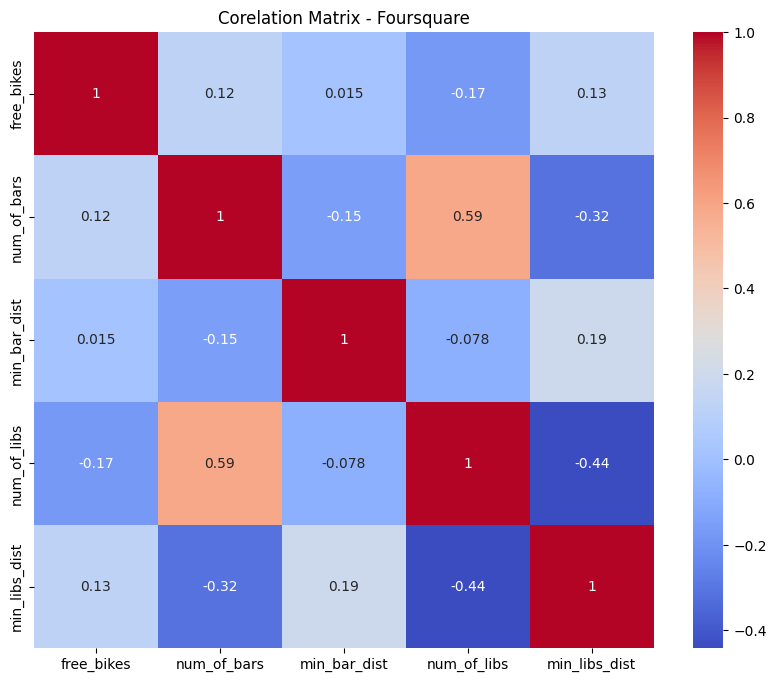

In [107]:
plt.figure(figsize=(10,8))
corr_matrix = df_bikes_radius_fsq[['free_bikes', 'num_of_bars', 'min_bar_dist', 'num_of_libs', 'min_libs_dist']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Corelation Matrix - Foursquare')
plt.show()

# with just under 200 rows gone, due to NaN values being dropped, there appear to be no overwhelming strong correlations between variables - the strong relationship present is between num_of_libs and number_of_bars...

In [108]:
# YELP results
# Before we do the correlation matrix, we should remove any NaN values from min_lib_distance adn min_bar_dist

df_bikes_bars_libs_cleaned = df_bikes_bars_libs.dropna()
df_bikes_bars_libs_cleaned

# We can see 30 rows have been removed - based on the 250 rows long that the YELP dataset is, if we had to guess, there are probaly less NaN's in the YELP dataset as opposed to the foursquare one, if we had all 717 results for YELP.

,bike_station#,latitude,longitude,free_bikes,num_of_bars,avg_bar_rating,min_bar_dist,num_of_libs,avg_lig_rating,min_lib_dist
0,0,43.665269,-79.319796,18,16,4.00000,216.73,1,3.500000,789.09
1,1,43.671420,-79.445947,2,10,3.05000,598.29,2,3.750000,688.66
2,2,43.666224,-79.317693,10,16,3.71875,341.48,1,3.500000,765.56
3,3,43.653236,-79.376716,4,50,3.87000,130.70,10,3.500000,561.35
4,4,43.663722,-79.380288,23,50,3.66000,62.99,9,3.944444,594.79
...,...,...,...,...,...,...,...,...,...,...
243,243,43.642830,-79.384090,9,50,3.61000,26.88,1,4.500000,999.66
244,244,43.651820,-79.474210,11,5,3.70000,116.05,3,3.666667,30.49
246,246,43.651678,-79.375233,1,50,3.80000,70.31,8,3.562500,435.89
247,247,43.651838,-79.378743,1,50,3.86000,89.87,8,3.812500,399.87


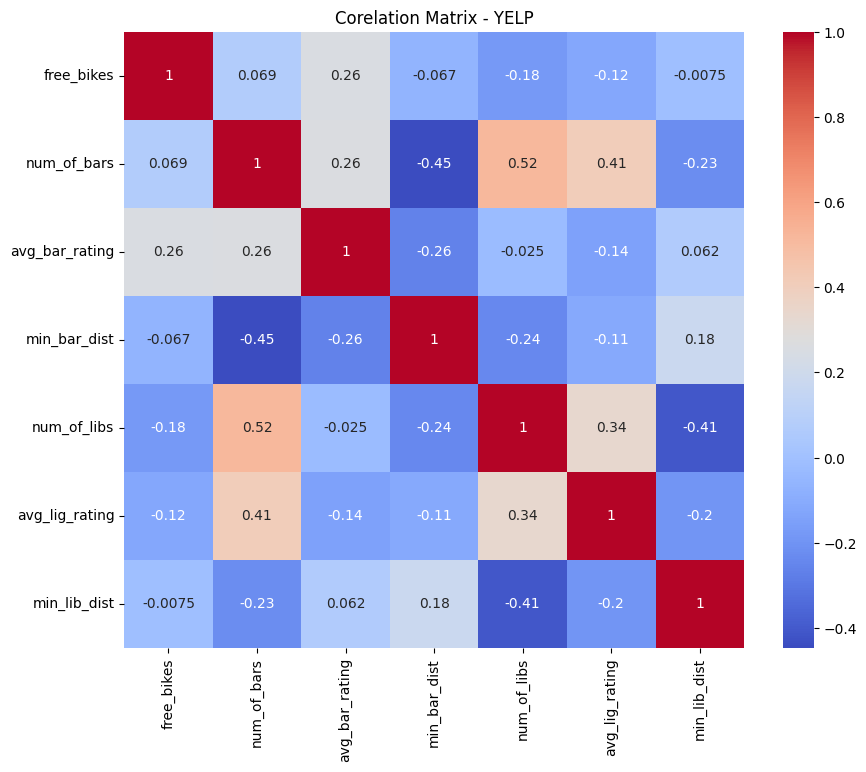

In [111]:
plt.figure(figsize=(10,8))
corr_matrix = df_bikes_bars_libs_cleaned[['free_bikes', 'num_of_bars', 'avg_bar_rating', 'min_bar_dist', 'num_of_libs', 'avg_lig_rating', 'min_lib_dist']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Corelation Matrix - YELP')
plt.show()

# We see a few move interesting relationships here given that YELP gives us ratings - num_of_bars and num_of_libs have a fairly strong positive correlation once again.
# Weirdly, min_bar_dist and num_of_bars have a negative relationship...

## In conlusion,

While the YELP dataset does give us more features, we still have more than double the data, even after removing NaN's from the Foursquare dataset and will be proceeding with modeling based on it.
If we had more time, we could have ran the YELP over 3 days to get the remainder of the results and would probably have been the better dataset to go with.